# Dipolar Droplets: critical atom number study

<a href="https://colab.research.google.com/github/viktorcikojevic/dipolar-droplets/blob/main/critical_atom_number.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:

import numpy as np
import random
from numpy import loadtxt
from scipy.optimize import curve_fit
import os
import matplotlib.pyplot as plt

import scipy.special
from scipy.optimize import fmin


In [9]:
# Get QMC data
import gdown

url = 'https://drive.google.com/uc?id=1RrM7HvxheAc7hO1sZUiJu0LdBrvr3u9L'
gdown.download(url, "energies-qmc.zip", quiet=False)

url = "https://drive.google.com/uc?id=1P_gBl2XgPKTweoVxLQcyi2brr9_H5gNB"
gdown.download(url, "experimental-data.zip", quiet=False)


Downloading...
From: https://drive.google.com/uc?id=1RrM7HvxheAc7hO1sZUiJu0LdBrvr3u9L
To: /Users/viktorcikojevic/Documents/dipolar-droplets/energies-qmc.zip
100%|██████████| 94.2k/94.2k [00:00<00:00, 994kB/s]
Downloading...
From: https://drive.google.com/uc?id=1P_gBl2XgPKTweoVxLQcyi2brr9_H5gNB
To: /Users/viktorcikojevic/Documents/dipolar-droplets/experimental-data.zip
100%|██████████| 2.36k/2.36k [00:00<00:00, 6.53MB/s]


'experimental-data.zip'

In [10]:
!unzip -n energies-qmc.zip
!unzip -n experimental-data.zip

Archive:  energies-qmc.zip
Archive:  experimental-data.zip


# Functions for $n_c$ estimation

In [11]:


def fdip(x):
    x  = x + 0.*1j
    EPS = 1.E-10
    res = np.piecewise(x, [np.abs(x-1) < EPS, np.abs(x-1) >= EPS], [0.+0.j, lambda x: (1 + 2.*x**2) / (1 - x**2) - 3*x**2*np.arctanh(np.sqrt(1-x**2)) / (1 - x**2)**1.5])
    return res.real 


def enFit(x, b, c):
    return b*x**c


def en_harmonic_oscillator(sr, sz):
     # calculate energy of the quantum harmonic oscillator with N particles and harmonic length harmonic_length
    return 0.5 * (sr**2 / 10000**2 + sz**2 / 100000**2)


def en_per_particle(sr, sz, nparticles, alpha, beta, gamma, include_ho=True):
    kappa = sr / sz
    kin = 0.25 * (2./sr**2 + 1./sz**2) 
    N = nparticles
    en_mflhy = np.sqrt(2)*np.pi**(-1.5)*N*alpha/(4*sr**2*sz) + np.pi**(-1.5*gamma)*beta*np.exp(gamma*np.log(N) - 2*gamma*np.log(sr) - gamma*np.log(sz))/(gamma + 1)**(3/2)
    en_int  = en_mflhy +  N/(2*(2*np.pi)**1.5 * sr**2 * sz) * (- 4*np.pi/3 * fdip(kappa) ) 
    return kin   + en_int  + (en_harmonic_oscillator(sr, sz) if include_ho else 0)

def min_en_per_particle(sr, sz, nparticles, alpha, beta, gamma, include_ho=True):
      return np.min(en_per_particle(sr, sz, nparticles, alpha, beta, gamma, include_ho))

def local_minima(array2d):
    # find local minima in 2d array.
    # Returns array of indices of local minima
    # True if the point is a local minimum
    return ((array2d <= np.roll(array2d,  1, 0)) &
            (array2d <= np.roll(array2d, -1, 0)) &
            (array2d <= np.roll(array2d,  1, 1)) &
            (array2d <= np.roll(array2d, -1, 1)))

def estimate_critical_atom_number(alpha, beta, gamma, include_ho=True, based_on='energy'):
    # Critical atom number is the number of atoms for which the energy of a system crosses zero.
    # The energy of a system is given by the second element of the tuple returned by en_particles.
    # The first element of the tuple is the optimal x_0.
    # Implement the root-finding algorithm to find the critical atom number
    # The function should return the critical atom number and the optimal x_0 for that atom number
    # The function should also return the energy of the system for the critical atom number.
    nparticles = 3*10**5

    

    

    iter_num = 0
    
    # Run the code below if the based_on is 'energy'
    if based_on == 'energy':
        ng = 500
        sr_range = np.linspace(4, 200, ng)
        sz_range = np.linspace(4, 2000, ng)
        # make meshgrid
        sr, sz = np.meshgrid(sr_range, sz_range)
        while True:
            nparticles_new = nparticles * 0.95
            en_0 = min_en_per_particle(sr, sz, nparticles, alpha, beta, gamma, include_ho=False)
            en_1 = min_en_per_particle(sr, sz, nparticles_new, alpha, beta, gamma, include_ho=False)
            if en_0 * en_1 < 0 and en_0 < 0 and en_1 > 0:
                break
            nparticles = nparticles_new
            iter_num += 1
            if iter_num > 4000:
                # Raise value error
                raise ValueError("Too many iterations")
                # break the will loop
                break
        return nparticles, en_0
        
    if based_on == 'size':
        ng = 500
        sr_range = np.linspace(0.1, 200, ng)
        sz_range = np.linspace(0.1, 2000, ng)
        # make meshgrid
        sr, sz = np.meshgrid(sr_range, sz_range)
        
        # Calculate the critical atom number in the following way:
        # 1. Find if there is a local minima of the energy for a given number of atoms
        # 2. if there exists local minimum, decrease the number of atoms. If not, break the loop
        while True:
            en_0 = en_per_particle(sr, sz, nparticles, alpha, beta, gamma, include_ho=False)
            local_min = local_minima(en_0)
            
            # if there exists local minimum, decrease the number of atoms. If not, break the loop
            if np.sum(local_min) > 0:
                nparticles_new = nparticles * 0.95
                nparticles = nparticles_new
                
                # print the sr and sz values for the local minima
                sr_local_min = sr.flatten()[local_min.flatten()]
                sz_local_min = sz.flatten()[local_min.flatten()]
                print(f"nparticles: {nparticles}, sr_local_min: {sr_local_min}, sz_local_min: {sz_local_min}")
                
                if np.min(en_0) > 0 and (np.min(sr_local_min) > sr_range[-2] or np.min(sz_local_min) > sz_range[-2]):
                    break
                
                iter_num += 1
                if iter_num > 4000 or nparticles < 10:
                    # Raise value error
                    raise ValueError("Too many iterations")
                    # break the will loop
                    break
            else:
                break

        nc = nparticles
        return nc, np.min(en_0)

## Physics parameters

In [12]:
a_s = 91.401702191
r_0 = 387.6   # https://www.wolframalpha.com/input?i=%28162Dy+mass%29+*+%28mu_0%29+*+%289.93+bohr+magneton%29%5E2+%2F+%284+pi+hbar%5E2%29+%2F+%28bohr+radius%29
# r_0 = 393.14   # https://www.wolframalpha.com/input?i=%28162+atomic+mass+unit%29+*+%28mu_0%29+*+%2810+bohr+magneton%29%5E2+%2F+%284+pi+hbar%5E2%29+%2F+%28bohr+radius%29
# r_0 = 398 # https://www.wolframalpha.com/input?i=%28164+atomic+mass+unit%29+*+%28mu_0%29+*+%2810+bohr+magneton%29%5E2+%2F+%284+pi+hbar%5E2%29+%2F+%28bohr+radius%29
# From Raul’s Thesis: m is the atomic mass, and Cdd = μ0 μ^2 sets the strength of the dipolar
# interaction, with μ = 9.93μB the magnetic dipole moment of 162Dy. We use dipolar units,
# obtained from the characteristic dipolar length r0 = m C_dd/ (4π \hbar^2) = 387.672168a0 and the
# dipolar scale of energy 0 = ~2
# 

## Test the $N_c$ function

In [13]:
# These are the MF+LHY estimations from IGOR. Let's try to reproduce some of these
!cat experimental-data/mean_field_IGOR.dat  

#a	N
60.5970075184  550.962558145
62.7356641274  630.484693517
64.8743207365  721.484505403
66.7271283591  798.254461363
68.8657849681  913.469004347
70.8615170839  1027.84403302
72.7158135034  1176.19595118
74.853725714  1323.46689853
76.9931267214  1540.22653908
78.9896032357  1762.532214
80.5587950671  1983.2180518
82.6974516761  2269.46206612
84.5532368924  2686.04636111
87.4057715689  3288.07864054
89.4044812784  3957.78164425
91.401702191  4605.99379639
93.9721098732  5930.74447925
96.3988486638  7383.40961091
98.2561226769  9038.277145
99.8275477035  10697.3506182



In [14]:

a_s = 91.401702191
a_s = a_s / r_0
alpha = 2*np.pi*a_s # * (1 - 1 / (3*(a_s / r_0)))
beta = 256*np.sqrt(np.pi)*a_s**(5/2)/15 + 128*np.sqrt(np.pi)*np.sqrt(a_s)/45
gamma = 1.5

n_c_best_possible_fit, min_energy = estimate_critical_atom_number(alpha, beta, gamma, include_ho=False, based_on='size')
n_c_best_possible_fit, min_energy

nparticles: 285000.0, sr_local_min: [38.15711423 37.75651303 37.35591182], sz_local_min: [1394.81983968 1414.85891784 1438.90581162]
nparticles: 270750.0, sr_local_min: [37.35591182 36.95531062], sz_local_min: [1378.78857715 1398.82765531]
nparticles: 257212.5, sr_local_min: [37.35591182 36.95531062 36.55470942], sz_local_min: [1322.67915832 1342.71823647 1362.75731463]
nparticles: 244351.875, sr_local_min: [36.55470942 36.15410822], sz_local_min: [1310.65571142 1330.69478958]
nparticles: 232134.28125, sr_local_min: [36.15410822 35.75350701], sz_local_min: [1274.58537074 1294.6244489 ]
nparticles: 220527.56718749998, sr_local_min: [35.75350701 35.35290581], sz_local_min: [1242.52284569 1262.56192385]
nparticles: 209501.18882812498, sr_local_min: [35.75350701 35.35290581 34.95230461], sz_local_min: [1194.42905812 1214.46813627 1234.50721443]
nparticles: 199026.12938671873, sr_local_min: [35.35290581 34.95230461 34.55170341], sz_local_min: [1166.3743487  1182.40561122 1202.44468938]
npar

(5778.815938771343, 9.96970220024108e-06)

In [15]:
ng = 400
sr_range = np.linspace(4, 100, ng)
sz_range = np.linspace(4, 1000, ng)
# make meshgrid
sr, sz = np.meshgrid(sr_range, sz_range)
nparticles = 100

np.min(en_per_particle(sr, sz, nparticles, alpha, beta, gamma, include_ho=False))

4.994387305328081e-05

In [16]:
# r_0 = 360.375
a_s = np.array([110, 101.572,  90, 80, 70, 60])
file = ["as110.dat", "as100.dat", "as90.dat", "as80.dat", "as70.dat", "as60.dat"]

# Recipe 1: E/N

Text(0.5, 1.0, 'E/N')

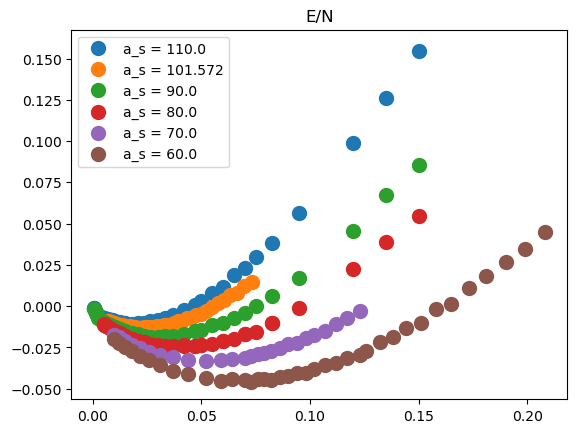

In [17]:
a_s
for i in range(len(a_s)):
    data = loadtxt("energies-qmc/data_clean/" + file[i],  float)
    # print("Reading data", "energies-qmc/" + file[i])
    rho_all = data[:, 0]
    en_all = data[:, 1] #  -  data[:,7]
    sen_all = data[:, 2]  # - data[:,6]
    alpha_mf = 2*np.pi*(a_s[i] / r_0) # * (1 - 1 / (3*(a_s[i] / r_0)))
    alpha_cherny    = 2*np.pi*(a_s[i] / r_0)  * (1 - 1 / (3*(a_s[i] / r_0)))
    # plt.errorbar(rho_all, en_all - alpha_mf * rho_all,sen_all, label=f"a_s = {a_s[i]}", marker='o', markersize=10, linestyle='None')
    
    
    en_dip = data[:,7]
    # plot en_dip, empty markers, but same colors as above. Make empty circles
    # plt.plot(rho_all, en_dip , marker='o', markersize=10, linestyle='None', markerfacecolor='none', markeredgecolor=plt.gca().lines[-1].get_color())
    
    
    plt.errorbar(rho_all, en_all , sen_all, label=f"a_s = {a_s[i]}", marker='o', markersize=10, linestyle='None')
    
    
plt.legend()
plt.title("E/N")
# plt.xlim(0, 0.03), plt.ylim(-0.02, 0)

# Recipe 2: $E/N - \alpha_{\rm MF} \rho$

Text(0.5, 1.0, 'E/N - alpha_mf * rho')

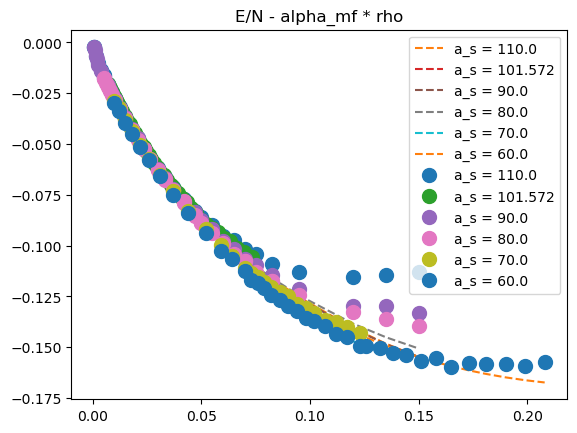

In [18]:
a_s
for i in range(len(a_s)):
    data = loadtxt("energies-qmc/data_clean/" + file[i],  float)
    # print("Reading data", "energies-qmc/" + file[i])
    rho_all = data[:, 0]
    en_all = data[:, 1] #  -  data[:,7]
    sen_all = data[:, 2]  # - data[:,6]
    alpha_mf = 2*np.pi*(a_s[i] / r_0) # * (1 - 1 / (3*(a_s[i] / r_0)))
    alpha_cherny    = 2*np.pi*(a_s[i] / r_0)  * (1 - 1 / (3*(a_s[i] / r_0)))
    # plt.errorbar(rho_all, en_all - alpha_mf * rho_all,sen_all, label=f"a_s = {a_s[i]}", marker='o', markersize=10, linestyle='None')
    
    
    en_dip = data[:,7]
    # plot en_dip, empty markers, but same colors as above. Make empty circles
    # plt.plot(rho_all, en_dip , marker='o', markersize=10, linestyle='None', markerfacecolor='none', markeredgecolor=plt.gca().lines[-1].get_color())
    
    
    plt.errorbar(rho_all, en_all - alpha_mf * rho_all, sen_all, label=f"a_s = {a_s[i]}", marker='o', markersize=10, linestyle='None')
    
    def enFit(x, a, b, c):
        return a*x + b*x**c
    popt, pcov = curve_fit(enFit, rho_all[rho_all<0.05] , en_all[rho_all<0.05] - alpha_mf * rho_all[rho_all<0.05],sigma=sen_all[rho_all<0.05], maxfev=10000)
    
    # Sort rho_all
    rho_all_sorted = np.sort(rho_all)
    plt.plot(rho_all_sorted, enFit(rho_all_sorted, *popt), label=f"a_s = {a_s[i]}", markeredgecolor=plt.gca().lines[-1].get_color(), linestyle='--')
    
    
plt.legend()
plt.title("E/N - alpha_mf * rho")
# plt.xlim(0, 0.03), plt.ylim(-0.02, 0)

# Recipe 3: $E/N - \alpha_{\rm Cherny} \rho$

(0.0, 0.2)

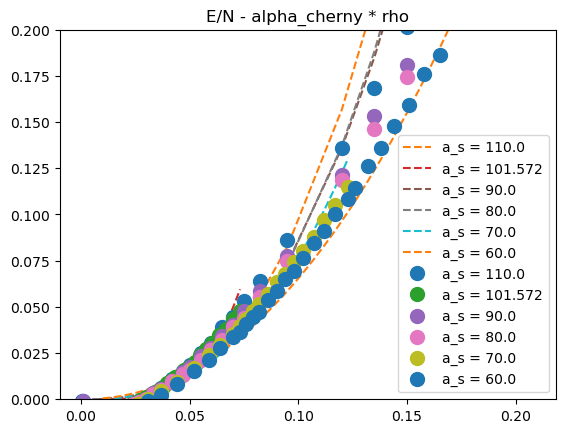

In [19]:
a_s
for i in range(len(a_s)):
    data = loadtxt("energies-qmc/data_clean/" + file[i],  float)
    # print("Reading data", "energies-qmc/" + file[i])
    rho_all = data[:, 0]
    en_all = data[:, 1] #  -  data[:,7]
    sen_all = data[:, 2]  # - data[:,6]
    alpha_mf = 2*np.pi*(a_s[i] / r_0) # * (1 - 1 / (3*(a_s[i] / r_0)))
    alpha_cherny    = 2*np.pi*(a_s[i] / r_0)  * (1 - 1 / (3*(a_s[i] / r_0)))
    # plt.errorbar(rho_all, en_all - alpha_mf * rho_all,sen_all, label=f"a_s = {a_s[i]}", marker='o', markersize=10, linestyle='None')
    
    
    en_dip = data[:,7]
    # plot en_dip, empty markers, but same colors as above. Make empty circles
    # plt.plot(rho_all, en_dip , marker='o', markersize=10, linestyle='None', markerfacecolor='none', markeredgecolor=plt.gca().lines[-1].get_color())
    
    
    plt.errorbar(rho_all, en_all - alpha_cherny * rho_all, sen_all, label=f"a_s = {a_s[i]}", marker='o', markersize=10, linestyle='None')
    
    def enFit(x, b, c):
        return b*x**c
    popt, pcov = curve_fit(enFit, rho_all , en_all - alpha_cherny * rho_all,sigma=sen_all, maxfev=10000)
    
    # Sort rho_all
    rho_all_sorted = np.sort(rho_all)
    plt.plot(rho_all_sorted, enFit(rho_all_sorted, *popt), label=f"a_s = {a_s[i]}", markeredgecolor=plt.gca().lines[-1].get_color(), linestyle='--')
    
    
plt.legend()
plt.title("E/N - alpha_cherny * rho")
plt.ylim(0, 0.2)
# plt.xlim(0, 0.03), plt.ylim(-0.02, 0)

# Recipe 4: STEP 1: Fit the energy to a function of the form $\alpha \rho + \beta\rho^\gamma$. Step 2: subtract the energy from the popt[0] * $\rho$

110.0 [-1.70961362  7.845302  ]
101.572 [-1.76643893  7.57242701]
90.0 [-1.92827889  7.15272629]
80.0 [-2.08835696  7.06241259]
70.0 [-2.04557653  5.94348875]
60.0 [-2.1050044   5.31955915]


(0.0, 0.21837499999999999)

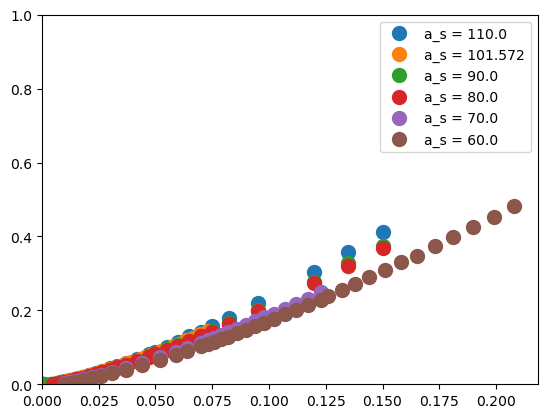

In [20]:
 
for i in range(len(a_s)):
    data = loadtxt("energies-qmc/data_clean/" + file[i],  float)
    # print("Reading data", "energies-qmc/" + file[i])
    rho_all = data[:, 0]
    en_all = data[:, 1] #  -  data[:,7]
    sen_all = data[:, 2]  # - data[:,6]
    alpha_mf = 2*np.pi*(a_s[i] / r_0) # * (1 - 1 / (3*(a_s[i] / r_0)))
    alpha_cherny    = 2*np.pi*(a_s[i] / r_0)  * (1 - 1 / (3*(a_s[i] / r_0)))
    # plt.errorbar(rho_all, en_all - alpha_mf * rho_all,sen_all, label=f"a_s = {a_s[i]}", marker='o', markersize=10, linestyle='None')
    
    
    en_dip = data[:,7]
    
    # plt.errorbar(rho_all, en_all - alpha_mf * rho_all, sen_all, label=f"a_s = {a_s[i]}", marker='o', markersize=10, linestyle='None')
    
    # STEP 1: Fit the energy to a function of the form a*x + b*x**c
    def enFit(x, a, b):
        return a*x + b*x**1.5
    popt, pcov = curve_fit(enFit, rho_all , en_all,sigma=sen_all, maxfev=10000)
    
    # Step 2: subtract the energy from the popt[0] * rho
    print(a_s[i], popt)
    # Step 2: 
    en_all = en_all - popt[0] * rho_all 
    
    plt.errorbar(rho_all, en_all, sen_all, label=f"a_s = {a_s[i]}", marker='o', markersize=10, linestyle='None')
    
        

    
plt.legend()
plt.ylim(0, 1)
plt.xlim(0)
# plt.xlim(0, 0.03), plt.ylim(-0.02, 0)

# Recipe 5: STEP 1: Fit the $E/N-E_{\rm dip}/N$ to a function of the form $\alpha \rho + \beta\rho^\gamma$. Step 2: subtract the $\alpha \rho$ from the $E/N-E_{\rm dip}/N$.



a_s = 110.0, popt[alpha,beta,gamma]=[0.07914027 4.30471128 1.48835675],alpha_mf=1.7831537249477667, beta_mf=1.4547172906617836
*** 2: a_s = 110.0, popt[beta,gamma]=[4.30471128 1.48835675],alpha_mf=1.7831537249477667, beta_mf=1.4547172906617836


a_s = 101.572, popt[alpha,beta,gamma]=[0.12714957 3.93590023 1.50206357],alpha_mf=1.6465317286399508, beta_mf=1.1729458591143356
*** 2: a_s = 101.572, popt[beta,gamma]=[3.93590024 1.50206357],alpha_mf=1.6465317286399508, beta_mf=1.1729458591143356


a_s = 90.0, popt[alpha,beta,gamma]=[-0.24504023  3.08333061  1.32326732],alpha_mf=1.4589439567754456, beta_mf=0.849465121632835
*** 2: a_s = 90.0, popt[beta,gamma]=[3.08333006 1.32326726],alpha_mf=1.4589439567754456, beta_mf=0.849465121632835


a_s = 80.0, popt[alpha,beta,gamma]=[0.02890036 2.88996398 1.41993762],alpha_mf=1.296839072689285, beta_mf=0.6228596085589179
*** 2: a_s = 80.0, popt[beta,gamma]=[2.88996428 1.41993765],alpha_mf=1.296839072689285, beta_mf=0.6228596085589179


a_s = 70.0, pop

(0.0, 0.21837499999999999)

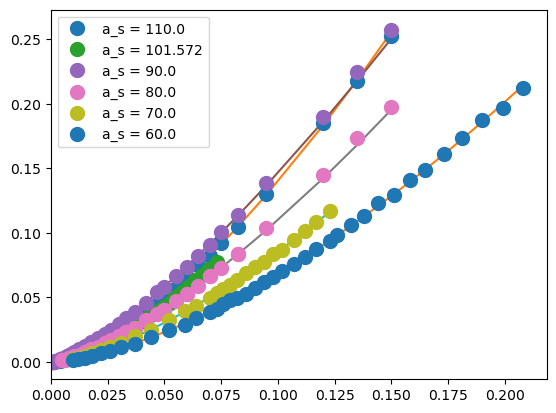

In [21]:
 
for i in range(len(a_s)):
    data = loadtxt("energies-qmc/data_clean/" + file[i],  float)
    # print("Reading data", "energies-qmc/" + file[i])
    rho_all = data[:, 0]
    en_all = data[:, 1] #  -  data[:,7]
    sen_all = data[:, 2]  # - data[:,6]
    alpha_mf = 2*np.pi*(a_s[i] / r_0) # * (1 - 1 / (3*(a_s[i] / r_0)))
    alpha_cherny    = 2*np.pi*(a_s[i] / r_0)  * (1 - 1 / (3*(a_s[i] / r_0)))
    # plt.errorbar(rho_all, en_all - alpha_mf * rho_all,sen_all, label=f"a_s = {a_s[i]}", marker='o', markersize=10, linestyle='None')
    
    
    en_dip = data[:,7]
    
    # plt.errorbar(rho_all, en_all - alpha_mf * rho_all, sen_all, label=f"a_s = {a_s[i]}", marker='o', markersize=10, linestyle='None')
    
    # STEP 1: Fit the energy to a function of the form a*x + b*x**c
    def enFit(x, a, b, c):
        return a*x + b*x**c
    popt, pcov = curve_fit(enFit, rho_all , en_all - en_dip,sigma=sen_all, maxfev=10000)
    
    beta_mf = 32*4*np.pi*(a_s[i]/r_0)*np.sqrt((a_s[i]/r_0)**3) / (3 * np.sqrt(np.pi)) * (1. + 1.5*  ((a_s[i]/r_0))**2) * 2./5 

    print(f"\n\na_s = {a_s[i]}, popt[alpha,beta,gamma]={popt},alpha_mf={alpha_mf}, beta_mf={beta_mf}")
    # Step 2: 
    en_all = en_all - popt[0] * rho_all - en_dip
    def enFit(x, b, c):
        return b*x**c
    popt, pcov = curve_fit(enFit, rho_all , en_all,sigma=sen_all, maxfev=10000)
    plt.errorbar(rho_all, en_all, sen_all, label=f"a_s = {a_s[i]}", marker='o', markersize=10, linestyle='None')
    # sort rho_all
    rho_all_sorted = np.sort(rho_all)
    plt.plot(rho_all_sorted, enFit(rho_all_sorted, *popt))
    print(f"*** 2: a_s = {a_s[i]}, popt[beta,gamma]={popt},alpha_mf={alpha_mf}, beta_mf={beta_mf}")
        

    
plt.legend()
# plt.ylim(0, 3)
plt.xlim(0)
# plt.xlim(0, 0.03), plt.ylim(-0.02, 0)

# Recipe 6: STEP 1: Fit the $E/N$ to a function of the form $\alpha \rho + \beta\rho^\gamma$. Step 2: Replace $\alpha$ by $\alpha_{\rm Cherny}$



a_s = 110.0, popt[alpha,beta,gamma]=[51.96637396  2.73719686],alpha_mf=1.7831537249477667, beta_mf=1.4547172906617836


a_s = 101.572, popt[alpha,beta,gamma]=[1857.12500224    3.9580198 ],alpha_mf=1.6465317286399508, beta_mf=1.1729458591143356


a_s = 90.0, popt[alpha,beta,gamma]=[35.21684523  2.62093721],alpha_mf=1.4589439567754456, beta_mf=0.849465121632835


a_s = 80.0, popt[alpha,beta,gamma]=[42.0734475   2.70120538],alpha_mf=1.296839072689285, beta_mf=0.6228596085589179


a_s = 70.0, popt[alpha,beta,gamma]=[28.81786398  2.5754194 ],alpha_mf=1.1347341886031244, beta_mf=0.43979799347127857


a_s = 60.0, popt[alpha,beta,gamma]=[8.78318351 2.1278778 ],alpha_mf=0.9726293045169637, beta_mf=0.29544634434488964


(0.0, 0.21837499999999999)

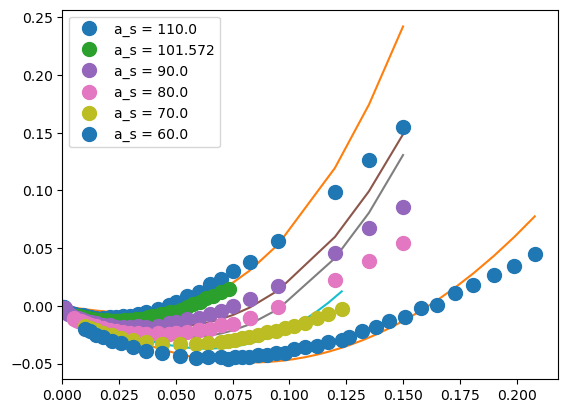

In [22]:
 
for i in range(len(a_s)):
    data = loadtxt("energies-qmc/data_clean/" + file[i],  float)
    # print("Reading data", "energies-qmc/" + file[i])
    rho_all = data[:, 0]
    en_all = data[:, 1] #  -  data[:,7]
    sen_all = data[:, 2]  # - data[:,6]
    alpha_mf = 2*np.pi*(a_s[i] / r_0) # * (1 - 1 / (3*(a_s[i] / r_0)))
    alpha_cherny    = 2*np.pi*(a_s[i] / r_0)  * (1 - 1 / (3*(a_s[i] / r_0)))
    # plt.errorbar(rho_all, en_all - alpha_mf * rho_all,sen_all, label=f"a_s = {a_s[i]}", marker='o', markersize=10, linestyle='None')
    
    
    en_dip = data[:,7]
    
    plt.errorbar(rho_all, en_all, sen_all, label=f"a_s = {a_s[i]}", marker='o', markersize=10, linestyle='None')
    
    # STEP 1: Fit the energy to a function of the form a*x + b*x**c
    def enFit(x, b, c):
        return alpha_cherny*x + b*x**c
    popt, pcov = curve_fit(enFit, rho_all , en_all,sigma=sen_all, maxfev=10000)
    
    beta_mf = 32*4*np.pi*(a_s[i]/r_0)*np.sqrt((a_s[i]/r_0)**3) / (3 * np.sqrt(np.pi)) * (1. + 1.5*  ((a_s[i]/r_0))**2) * 2./5 

    print(f"\n\na_s = {a_s[i]}, popt[alpha,beta,gamma]={popt},alpha_mf={alpha_mf}, beta_mf={beta_mf}")
    # sort rho_all  
    rho_all_sorted = np.sort(rho_all)
    plt.plot(rho_all_sorted, enFit(rho_all_sorted, *popt))
        

    
plt.legend()
# plt.ylim(0, 3)
plt.xlim(0)
# plt.xlim(0, 0.03), plt.ylim(-0.02, 0)

# Recipe 7: STEP 1: Fit the $E_{\rm kin}/N$ to a function of the form $\alpha \rho + \beta\rho^\gamma$. Step 2: Use $\beta\rho^\gamma$ instead of the LHY term



a_s = 110.0, popt[alpha,beta,gamma]=[0.11883385 3.28002703 1.52530295]


a_s = 101.572, popt[alpha,beta,gamma]=[0.22125297 3.19806879 1.59521286]


a_s = 90.0, popt[alpha,beta,gamma]=[-0.04210241  2.23638408  1.35239519]


a_s = 80.0, popt[alpha,beta,gamma]=[0.27080808 2.38773351 1.56886656]


a_s = 70.0, popt[alpha,beta,gamma]=[ 2.16761928e+03 -2.16630151e+03  9.99907699e-01]


a_s = 60.0, popt[alpha,beta,gamma]=[0.48306191 2.22129791 1.79371164]


(0.0, 0.21837499999999999)

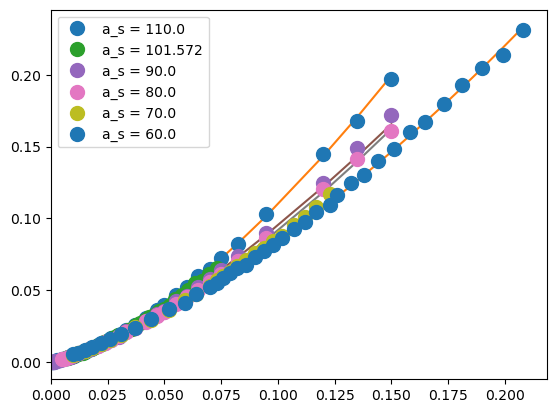

In [23]:
 
for i in range(len(a_s)):
    data = loadtxt("energies-qmc/data_clean/" + file[i],  float)
    # print("Reading data", "energies-qmc/" + file[i])
    rho_all = data[:, 0]
    
    en_all = data[:, 1] #  -  data[:,7]
    sen_all = data[:, 2]  # - data[:,6]
    kin_en = data[:, 3]
    sen_kin = data[:, 4]
    
    alpha_mf = 2*np.pi*(a_s[i] / r_0) # * (1 - 1 / (3*(a_s[i] / r_0)))
    
    
    plt.errorbar(rho_all, kin_en, sen_kin, label=f"a_s = {a_s[i]}", marker='o', markersize=10, linestyle='None')
    
    # STEP 1: Fit the energy to a function of the form a*x + b*x**c
    def enFit(x, a, b, c):
        return a*x + b*x**c
    popt, pcov = curve_fit(enFit, rho_all , kin_en,sigma=sen_kin, maxfev=10000)
    
    print(f"\n\na_s = {a_s[i]}, popt[alpha,beta,gamma]={popt}")
    # sort rho_all
    idx = np.argsort(rho_all)
    rho_all = rho_all[idx]
    plt.plot(rho_all, enFit(rho_all, *popt))
        

    
plt.legend()
# plt.ylim(0, 3)
plt.xlim(0)
# plt.xlim(0, 0.03), plt.ylim(-0.02, 0)

# Estimate $n_c$ with recipe 5

In [24]:

a_s = np.array([110, 101.572,  90, 80, 70, 60])
file = ["as110.dat", "as100.dat", "as90.dat", "as80.dat", "as70.dat", "as60.dat"]
# extension = "_2" #is either "" or "_2"
enmax = np.array([0.015, 0.03, 0.05, 0.05])
# approximate estimate of equilibrium density
# rho_0_arr = np.array([0.018133025814418047, 0.022067711461453077,  0.03056689762975153,  0.03896986119629473]) 
rho_0_arr = np.array([0.02 , 0.025 ,  0.03 ,  0.04, 0.05, 0.069]) 
rho_max_arr = 2.0 * rho_0_arr

!mkdir results/critical-atom-numbers/recipe-5-nc
fout = open(f"results/critical-atom-numbers/recipe-5-nc/functionals_E_N.dat", 'w', buffering=1)
# write header: string_out = f"{a_s[i]:.2f} {n_c_best_possible_fit:.5e} {rho_min_x:.4e} {rho_max_x:.4e}  {alpha:.5e} {popt[0]:.5e} {popt[1]:.5e} {popt[2]:.5e}  {min_energy:.5e}   \n"
string_out = f"# as  n_c_best_possible_fit  rho_min_x  rho_max_x  alpha  popt[0]  popt[1]  popt[2]  min_energy  \n"
fout.write(string_out)
for rho_min_x in np.arange(0.7, 0.71, 0.1):
  for rho_max_x in np.arange(1.9, 1.91, 0.1):
    for i in range(len(a_s)):
        rho_min = rho_min_x * rho_0_arr
        rho_max = rho_max_x * rho_0_arr


        print(f"analyzing a_s = {a_s[i]:.3f}")

        data = loadtxt("energies-qmc/data_clean/" + file[i],  float)
        print("Reading data", "energies-qmc/" + file[i])
        rho_all = data[:, 0]
        en_all = data[:, 1] #  -  data[:,7]
        sen_all = data[:, 2]  # - data[:,6]
        en_dip = data[:,7]

        en_all = en_all - en_dip

        w = np.logical_and(rho_all > rho_min[i], rho_all < rho_max[i])
        rho_all_w = rho_all[w]
        en_all_w = en_all[w]
        sen_all_w = sen_all[w]

        try:
            
            alpha_mf = 2*np.pi*(a_s[i] / r_0) # * (1 - 1 / (3*(a_s[i] / r_0)))
            alpha_cherny = 2*np.pi*(a_s[i] / r_0)  * (1 - 1 / (3*(a_s[i] / r_0)))
            
            def enFit(x, a, b, c):
              return a*x + b*x**c
            
            popt, pcov = curve_fit(enFit, rho_all_w, en_all_w,sigma=sen_all_w, maxfev=10000)
            alpha, beta, gamma = popt
            n_c_best_possible_fit, min_energy = estimate_critical_atom_number(alpha, beta, gamma, based_on='size')
            
            
            
            alpha_opt = popt[0]
            # popt[0] = 2*np.pi*(a_s[i] / r_0)  * (1 - 1 / (3*(a_s[i] / r_0)))
            # n_c_alpha_cherny = estimate_critical_atom_number(popt)

            # popt[0] = 2*np.pi*(a_s[i] / r_0)  
            # n_c_alpha_mf = estimate_critical_atom_number(popt)

            # popt[0] = 2*np.pi*(a_s[i] / r_0) / 10  
            # n_c_alpha_mf_over_10 = estimate_critical_atom_number(popt)

            # string_out = f"{rho_min_x} {a_s[i]} {alpha_opt} {popt[1]} {popt[2]} {n_c_best_possible_fit} {n_c_alpha_cherny} {n_c_alpha_mf} {n_c_alpha_mf_over_10} \n"
            string_out = f"{a_s[i]:.2f} {n_c_best_possible_fit:.5e} {rho_min_x:.4e} {rho_max_x:.4e}  {alpha:.5e} {popt[0]:.5e} {popt[1]:.5e} {popt[2]:.5e}  {min_energy:.5e}   \n"
            fout.write(string_out)
            print(string_out)
        except Exception as error:
            print('Caught this error: ' + repr(error))


mkdir: results/critical-atom-numbers/recipe-5-nc: File exists
analyzing a_s = 110.000
Reading data energies-qmc/as110.dat
nparticles: 285000.0, sr_local_min: [17.3258517  16.9252505  16.5246493  16.1240481  15.72344689 15.32284569
 14.92224449 14.52164329 14.12104208 13.72044088], sz_local_min: [ 705.4755511   733.53026052  769.6006012   801.66312625  841.74128257
  881.81943888  925.90541082  978.00701403 1030.10861723 1086.21803607]
nparticles: 270750.0, sr_local_min: [16.9252505  16.5246493  16.1240481  15.72344689 15.32284569 14.92224449
 14.52164329 14.12104208 13.72044088 13.31983968], sz_local_min: [ 701.46773547  733.53026052  765.59278557  801.66312625  841.74128257
  881.81943888  929.91322645  978.00701403 1034.11643287 1094.23366733]
nparticles: 257212.5, sr_local_min: [16.9252505  16.5246493  16.1240481  15.72344689 15.32284569 14.92224449
 14.52164329 14.12104208 13.72044088 13.31983968], sz_local_min: [ 669.40521042  697.45991984  729.52244489  761.58496994  801.66312625

# Estimate $n_c$ with recipe 1

In [25]:

a_s = np.array([110, 101.572,  90, 80, 70, 60])
file = ["as110.dat", "as100.dat", "as90.dat", "as80.dat", "as70.dat", "as60.dat"]
# extension = "_2" #is either "" or "_2"
enmax = np.array([0.015, 0.03, 0.05, 0.05])
# approximate estimate of equilibrium density
# rho_0_arr = np.array([0.018133025814418047, 0.022067711461453077,  0.03056689762975153,  0.03896986119629473]) 
rho_0_arr = np.array([0.02 , 0.025 ,  0.03 ,  0.04, 0.05, 0.069]) 
rho_max_arr = 2.0 * rho_0_arr

!mkdir results/critical-atom-numbers/recipe-1-nc
fout = open(f"results/critical-atom-numbers/recipe-1-nc/functionals_E_N.dat", 'w', buffering=1)
# write header: string_out = f"{a_s[i]:.2f} {n_c_best_possible_fit:.5e} {rho_min_x:.4e} {rho_max_x:.4e}  {alpha:.5e} {popt[0]:.5e} {popt[1]:.5e} {popt[2]:.5e}  {min_energy:.5e}   \n"
string_out = f"# as  n_c_best_possible_fit  rho_min_x  rho_max_x  alpha  popt[0]  popt[1]  popt[2]  min_energy  \n"
fout.write(string_out)
for rho_min_x in np.arange(0.7, 0.71, 0.1):
  for rho_max_x in np.arange(1.9, 1.91, 0.1):
    for i in range(len(a_s)):
        rho_min = rho_min_x * rho_0_arr
        rho_max = rho_max_x * rho_0_arr


        print(f"analyzing a_s = {a_s[i]:.3f}")

        data = loadtxt("energies-qmc/data_clean/" + file[i],  float)
        print("Reading data", "energies-qmc/" + file[i])
        rho_all = data[:, 0]
        en_all = data[:, 1] #  -  data[:,7]
        sen_all = data[:, 2]  # - data[:,6]
        en_dip = data[:,7]

        en_all = en_all

        w = np.logical_and(rho_all > rho_min[i], rho_all < rho_max[i])
        rho_all_w = rho_all[w]
        en_all_w = en_all[w]
        sen_all_w = sen_all[w]

        try:
            
            alpha_mf = 2*np.pi*(a_s[i] / r_0) # * (1 - 1 / (3*(a_s[i] / r_0)))
            alpha_cherny = 2*np.pi*(a_s[i] / r_0)  * (1 - 1 / (3*(a_s[i] / r_0)))
            
            def enFit(x, a, b, c):
              return a*x + b*x**c
            
            popt, pcov = curve_fit(enFit, rho_all_w, en_all_w,sigma=sen_all_w, maxfev=10000)
            alpha, beta, gamma = popt
            n_c_best_possible_fit, min_energy = estimate_critical_atom_number(alpha, beta, gamma, based_on='size')
            
            
            
            alpha_opt = popt[0]
            # popt[0] = 2*np.pi*(a_s[i] / r_0)  * (1 - 1 / (3*(a_s[i] / r_0)))
            # n_c_alpha_cherny = estimate_critical_atom_number(popt)

            # popt[0] = 2*np.pi*(a_s[i] / r_0)  
            # n_c_alpha_mf = estimate_critical_atom_number(popt)

            # popt[0] = 2*np.pi*(a_s[i] / r_0) / 10  
            # n_c_alpha_mf_over_10 = estimate_critical_atom_number(popt)

            # string_out = f"{rho_min_x} {a_s[i]} {alpha_opt} {popt[1]} {popt[2]} {n_c_best_possible_fit} {n_c_alpha_cherny} {n_c_alpha_mf} {n_c_alpha_mf_over_10} \n"
            string_out = f"{a_s[i]:.2f} {n_c_best_possible_fit:.5e} {rho_min_x:.4e} {rho_max_x:.4e}  {alpha:.5e} {popt[0]:.5e} {popt[1]:.5e} {popt[2]:.5e}  {min_energy:.5e}   \n"
            fout.write(string_out)
            print(string_out)
        except Exception as error:
            print('Caught this error: ' + repr(error))


mkdir: results/critical-atom-numbers/recipe-1-nc: File exists
analyzing a_s = 110.000
Reading data energies-qmc/as110.dat
nparticles: 285000.0, sr_local_min: [13.31983968 12.91923848 12.51863727 12.11803607 11.71743487 11.31683367
 10.91623246 10.51563126 10.11503006  9.71442886  9.31382766  8.91322645
  8.51262525  8.11202405  7.71142285  7.31082164], sz_local_min: [ 541.15511022  569.20981964  605.28016032  641.350501    685.43647295
  729.52244489  781.6240481   841.74128257  909.8741483   982.01482966
 1066.17895792 1162.36653307 1274.58537074 1402.83547094 1551.1246493
 1723.46072144]
nparticles: 270750.0, sr_local_min: [13.31983968 12.91923848 12.51863727 12.11803607 11.71743487 11.31683367
 10.91623246 10.51563126 10.11503006  9.71442886  9.31382766  8.91322645
  8.51262525  8.11202405  7.71142285  7.31082164], sz_local_min: [ 513.1004008   541.15511022  577.2254509   613.29579158  649.36613226
  697.45991984  745.55370741  801.66312625  861.78036072  933.92104208
 1014.07735471

# Estimate $n_c$ with recipe 3

In [26]:

a_s = np.array([110, 101.572,  90, 80, 70, 60])
file = ["as110.dat", "as100.dat", "as90.dat", "as80.dat", "as70.dat", "as60.dat"]
# extension = "_2" #is either "" or "_2"
enmax = np.array([0.015, 0.03, 0.05, 0.05])
# approximate estimate of equilibrium density
# rho_0_arr = np.array([0.018133025814418047, 0.022067711461453077,  0.03056689762975153,  0.03896986119629473]) 
rho_0_arr = np.array([0.02 , 0.025 ,  0.03 ,  0.04, 0.05, 0.069]) 
rho_max_arr = 2.0 * rho_0_arr

!mkdir results/critical-atom-numbers/recipe-3-nc
fout = open(f"results/critical-atom-numbers/recipe-3-nc/functionals_E_N.dat", 'w', buffering=1)
# write header: string_out = f"{a_s[i]:.2f} {n_c_best_possible_fit:.5e} {rho_min_x:.4e} {rho_max_x:.4e}  {alpha:.5e} {popt[0]:.5e} {popt[1]:.5e} {popt[2]:.5e}  {min_energy:.5e}   \n"
string_out = f"# as  n_c_best_possible_fit  rho_min_x  rho_max_x  alpha  popt[0]  popt[1]  popt[2]  min_energy  \n"
fout.write(string_out)
for rho_min_x in np.arange(0.7, 0.71, 0.1):
  for rho_max_x in np.arange(1.9, 1.91, 0.1):
    for i in range(len(a_s)):
        rho_min = rho_min_x * rho_0_arr
        rho_max = rho_max_x * rho_0_arr


        print(f"analyzing a_s = {a_s[i]:.3f}")

        data = loadtxt("energies-qmc/data_clean/" + file[i],  float)
        print("Reading data", "energies-qmc/" + file[i])
        rho_all = data[:, 0]
        en_all = data[:, 1] #  -  data[:,7]
        sen_all = data[:, 2]  # - data[:,6]
        en_dip = data[:,7]

        en_all = en_all

        w = np.logical_and(rho_all > rho_min[i], rho_all < rho_max[i])
        rho_all_w = rho_all[w]
        en_all_w = en_all[w]
        sen_all_w = sen_all[w]

        try:
            
            alpha_mf = 2*np.pi*(a_s[i] / r_0) # * (1 - 1 / (3*(a_s[i] / r_0)))
            alpha_cherny = 2*np.pi*(a_s[i] / r_0)  * (1 - 1 / (3*(a_s[i] / r_0)))
            
            def enFit(x, a, b, c):
              return a*x + b*x**c
            
            en_all_w = en_all_w - alpha_cherny * rho_all_w

            popt, pcov = curve_fit(enFit, rho_all_w, en_all_w,sigma=sen_all_w, maxfev=10000)
            alpha, beta, gamma = popt
            n_c_best_possible_fit, min_energy = estimate_critical_atom_number(alpha, beta, gamma, based_on='size')
            
            
            
            alpha_opt = popt[0]
            # popt[0] = 2*np.pi*(a_s[i] / r_0)  * (1 - 1 / (3*(a_s[i] / r_0)))
            # n_c_alpha_cherny = estimate_critical_atom_number(popt)

            # popt[0] = 2*np.pi*(a_s[i] / r_0)  
            # n_c_alpha_mf = estimate_critical_atom_number(popt)

            # popt[0] = 2*np.pi*(a_s[i] / r_0) / 10  
            # n_c_alpha_mf_over_10 = estimate_critical_atom_number(popt)

            # string_out = f"{rho_min_x} {a_s[i]} {alpha_opt} {popt[1]} {popt[2]} {n_c_best_possible_fit} {n_c_alpha_cherny} {n_c_alpha_mf} {n_c_alpha_mf_over_10} \n"
            string_out = f"{a_s[i]:.2f} {n_c_best_possible_fit:.5e} {rho_min_x:.4e} {rho_max_x:.4e}  {alpha:.5e} {popt[0]:.5e} {popt[1]:.5e} {popt[2]:.5e}  {min_energy:.5e}   \n"
            fout.write(string_out)
            print(string_out)
        except Exception as error:
            print('Caught this error: ' + repr(error))


mkdir: results/critical-atom-numbers/recipe-3-nc: File exists
analyzing a_s = 110.000
Reading data energies-qmc/as110.dat
nparticles: 285000.0, sr_local_min: [14.92224449 14.52164329 14.12104208 13.72044088 13.31983968 12.91923848
 12.51863727 12.11803607 11.71743487 11.31683367 10.91623246 10.51563126
 10.11503006  9.71442886], sz_local_min: [ 613.29579158  645.35831663  677.42084168  713.49118236  757.57715431
  801.66312625  849.75691383  905.86633267  965.98356713 1034.11643287
 1110.26492986 1194.42905812 1286.60881764 1394.81983968]
nparticles: 270750.0, sr_local_min: [14.92224449 14.52164329 14.12104208 13.72044088 13.31983968 12.91923848
 12.51863727 12.11803607 11.71743487 11.31683367 10.91623246 10.51563126
 10.11503006  9.71442886], sz_local_min: [ 585.24108216  613.29579158  645.35831663  681.42865731  721.50681363
  761.58496994  809.67875752  861.78036072  917.88977956  982.01482966
 1054.15551102 1134.31182365 1222.48376754 1326.68697395]
nparticles: 257212.5, sr_local_m

# Estimate $n_c$ with recipe 6

In [27]:

a_s = np.array([110, 101.572,  90, 80, 70, 60])
file = ["as110.dat", "as100.dat", "as90.dat", "as80.dat", "as70.dat", "as60.dat"]
# extension = "_2" #is either "" or "_2"
enmax = np.array([0.015, 0.03, 0.05, 0.05])
# approximate estimate of equilibrium density
# rho_0_arr = np.array([0.018133025814418047, 0.022067711461453077,  0.03056689762975153,  0.03896986119629473]) 
rho_0_arr = np.array([0.02 , 0.025 ,  0.03 ,  0.04, 0.05, 0.069]) 
rho_max_arr = 2.0 * rho_0_arr

!mkdir results/critical-atom-numbers/recipe-6-nc
fout = open(f"results/critical-atom-numbers/recipe-6-nc/functionals_E_N.dat", 'w', buffering=1)
# write header: string_out = f"{a_s[i]:.2f} {n_c_best_possible_fit:.5e} {rho_min_x:.4e} {rho_max_x:.4e}  {alpha:.5e} {popt[0]:.5e} {popt[1]:.5e} {popt[2]:.5e}  {min_energy:.5e}   \n"
string_out = f"# as  n_c_best_possible_fit  rho_min_x  rho_max_x  alpha  popt[0]  popt[1]  popt[2]  min_energy  \n"
fout.write(string_out)
for rho_min_x in np.arange(0.7, 0.71, 0.1):
  for rho_max_x in np.arange(1.9, 1.91, 0.1):
    for i in range(len(a_s)):
        rho_min = rho_min_x * rho_0_arr
        rho_max = rho_max_x * rho_0_arr


        print(f"analyzing a_s = {a_s[i]:.3f}")

        data = loadtxt("energies-qmc/data_clean/" + file[i],  float)
        print("Reading data", "energies-qmc/" + file[i])
        rho_all = data[:, 0]
        en_all = data[:, 1] #  -  data[:,7]
        sen_all = data[:, 2]  # - data[:,6]
        en_dip = data[:,7]

        en_all = en_all

        w = np.logical_and(rho_all > rho_min[i], rho_all < rho_max[i])
        rho_all_w = rho_all[w]
        en_all_w = en_all[w]
        sen_all_w = sen_all[w]

        try:
            
            alpha_mf = 2*np.pi*(a_s[i] / r_0) # * (1 - 1 / (3*(a_s[i] / r_0)))
            alpha_cherny = 2*np.pi*(a_s[i] / r_0)  * (1 - 1 / (3*(a_s[i] / r_0)))
            
            def enFit(x, b, c):
              return b*x**c
            
            en_all_w = en_all_w  - alpha_cherny * rho_all_w
            
            popt, pcov = curve_fit(enFit, rho_all_w, en_all_w,sigma=sen_all_w, maxfev=10000)
            beta, gamma = popt
            alpha = alpha_cherny
            n_c_best_possible_fit, min_energy = estimate_critical_atom_number(alpha, beta, gamma, based_on='size')
            
            
            
            alpha_opt = popt[0]
            # popt[0] = 2*np.pi*(a_s[i] / r_0)  * (1 - 1 / (3*(a_s[i] / r_0)))
            # n_c_alpha_cherny = estimate_critical_atom_number(popt)

            # popt[0] = 2*np.pi*(a_s[i] / r_0)  
            # n_c_alpha_mf = estimate_critical_atom_number(popt)

            # popt[0] = 2*np.pi*(a_s[i] / r_0) / 10  
            # n_c_alpha_mf_over_10 = estimate_critical_atom_number(popt)

            # string_out = f"{rho_min_x} {a_s[i]} {alpha_opt} {popt[1]} {popt[2]} {n_c_best_possible_fit} {n_c_alpha_cherny} {n_c_alpha_mf} {n_c_alpha_mf_over_10} \n"
            string_out = f"{a_s[i]:.2f} {n_c_best_possible_fit:.5e} {rho_min_x:.4e} {rho_max_x:.4e}  {alpha:.5e} {popt[0]:.5e} {popt[1]:.5e} {popt[2]:.5e}  {min_energy:.5e}   \n"
            fout.write(string_out)
            print(string_out)
        except Exception as error:
            print('Caught this error: ' + repr(error))


mkdir: results/critical-atom-numbers/recipe-6-nc: File exists
analyzing a_s = 110.000
Reading data energies-qmc/as110.dat
nparticles: 285000.0, sr_local_min: [46.16913828 44.96733467 44.16613226 43.36492986 42.96432866 42.56372745
 41.76252505 41.36192385 40.96132265 40.56072144 40.16012024 39.75951904
 39.35891784 38.95831663 38.55771543 38.15711423 37.75651303 37.35591182
 36.95531062 36.55470942 36.15410822 35.75350701 35.35290581 34.95230461
 34.55170341 34.1511022  33.750501   33.3498998  32.9492986  32.54869739
 32.14809619 31.74749499 31.34689379 30.94629259 30.54569138 30.14509018
 29.74448898 29.34388778 28.94328657 28.54268537 28.14208417 27.74148297
 27.34088176 26.94028056 26.53967936 26.13907816 25.73847695 25.33787575
 24.93727455 24.53667335 24.13607214 23.73547094 23.33486974], sz_local_min: [ 517.10821643  545.16292585  565.20200401  585.24108216  597.26452906
  609.28797595  629.32705411  641.350501    657.38176353  669.40521042
  681.42865731  693.45210421  709.48336

# Estimate $n_c$ with recipe 7

In [28]:

a_s = np.array([110, 101.572,  90, 80, 70, 60])
file = ["as110.dat", "as100.dat", "as90.dat", "as80.dat", "as70.dat", "as60.dat"]
# extension = "_2" #is either "" or "_2"
enmax = np.array([0.015, 0.03, 0.05, 0.05])
# approximate estimate of equilibrium density
# rho_0_arr = np.array([0.018133025814418047, 0.022067711461453077,  0.03056689762975153,  0.03896986119629473]) 
rho_0_arr = np.array([0.02 , 0.025 ,  0.03 ,  0.04, 0.05, 0.069]) 
rho_max_arr = 2.0 * rho_0_arr

!mkdir results/critical-atom-numbers/recipe-7-nc
fout = open(f"results/critical-atom-numbers/recipe-7-nc/functionals_E_N.dat", 'w', buffering=1)
# fout.write("# {rho_min_x} {a_s[i]} {popt[0]} {popt[1]} {popt[2]} {n_c}\n")
# Write the first line, which is the header: string_out = f"{a_s[i]:.2f}  {n_c_best_possible_fit:.5e}  {rho_min_x:.3e} {rho_max_x:.3e} {alpha:.5e} {popt[0]:.5e} {popt[1]:.5e} {popt[2]:.5e}    \n"
string_out = f"# a_s  n_c_best_possible_fit  rho_min_x  rho_max_x  alpha  alpha_opt  beta  gamma  min_energy  \n"
fout.write(string_out)
for rho_min_x in np.arange(0.7, 0.71, 0.1):
  for rho_max_x in np.arange(1.9, 1.91, 0.1):
    for i in range(len(a_s)):
        rho_min = rho_min_x * rho_0_arr
        rho_max = rho_max_x * rho_0_arr


        print(f"analyzing a_s = {a_s[i]:.3f}")

        data = loadtxt("energies-qmc/data_clean/" + file[i],  float)
        print("Reading data", "energies-qmc/" + file[i])
        rho_all = data[:, 0]
        en_all = data[:, 1] #  -  data[:,7]
        sen_all = data[:, 2]  # - data[:,6]
        kin_en = data[:,3]
        sen_kin = data[:,4]        

        en_all = en_all

        w = np.logical_and(rho_all > rho_min[i], rho_all < rho_max[i])
        rho_all_w = rho_all[w]
        en_all_w = kin_en[w]
        sen_all_w = sen_kin[w]

        try:
            
            alpha_mf = 2*np.pi*(a_s[i] / r_0) # * (1 - 1 / (3*(a_s[i] / r_0)))
            alpha_cherny = 2*np.pi*(a_s[i] / r_0)  * (1 - 1 / (3*(a_s[i] / r_0)))
            
            def enFit(x, a, b, c):
              return a*x + b*x**c
            
            
            
            popt, pcov = curve_fit(enFit, rho_all_w, en_all_w,sigma=sen_all_w, maxfev=10000)
            alpha, beta, gamma = popt
            alpha = alpha_mf
            n_c_best_possible_fit, min_energy = estimate_critical_atom_number(alpha, beta, gamma, based_on='size')
            
            
            
            alpha_opt = popt[0]
            # popt[0] = 2*np.pi*(a_s[i] / r_0)  * (1 - 1 / (3*(a_s[i] / r_0)))
            # n_c_alpha_cherny = estimate_critical_atom_number(popt)

            # popt[0] = 2*np.pi*(a_s[i] / r_0)  
            # n_c_alpha_mf = estimate_critical_atom_number(popt)

            # popt[0] = 2*np.pi*(a_s[i] / r_0) / 10  
            # n_c_alpha_mf_over_10 = estimate_critical_atom_number(popt)

            # string_out = f"{rho_min_x} {a_s[i]} {alpha_opt} {popt[1]} {popt[2]} {n_c_best_possible_fit} {n_c_alpha_cherny} {n_c_alpha_mf} {n_c_alpha_mf_over_10} \n"
            string_out = f"{a_s[i]:.2f}  {n_c_best_possible_fit:.5e}  {rho_min_x:.3e} {rho_max_x:.3e} {alpha:.5e} {popt[0]:.5e} {popt[1]:.5e} {popt[2]:.5e}    \n"
            fout.write(string_out)
            print(string_out)
        except Exception as error:
            print('Caught this error: ' + repr(error))


mkdir: results/critical-atom-numbers/recipe-7-nc: File exists
analyzing a_s = 110.000
Reading data energies-qmc/as110.dat
nparticles: 285000.0, sr_local_min: [86.22925852], sz_local_min: [2000.]
nparticles: 270750.0, sr_local_min: [85.02745491], sz_local_min: [2000.]
nparticles: 257212.5, sr_local_min: [83.8256513], sz_local_min: [2000.]
nparticles: 244351.875, sr_local_min: [82.6238477], sz_local_min: [2000.]
nparticles: 232134.28125, sr_local_min: [81.82264529], sz_local_min: [2000.]
nparticles: 220527.56718749998, sr_local_min: [81.02144289], sz_local_min: [2000.]
nparticles: 209501.18882812498, sr_local_min: [80.22024048], sz_local_min: [2000.]
nparticles: 199026.12938671873, sr_local_min: [79.81963928], sz_local_min: [1975.95310621]
nparticles: 189074.8229173828, sr_local_min: [79.41903808], sz_local_min: [1935.8749499]
nparticles: 179621.08177151365, sr_local_min: [79.41903808], sz_local_min: [1891.78897796]
nparticles: 170640.02768293797, sr_local_min: [79.01843687], sz_local_mi

# Estimate $n_c$ with recipe 42: MFLHY

In [29]:

a_s = np.array([110, 101.572,  90, 80, 70, 60])
file = ["as110.dat", "as100.dat", "as90.dat", "as80.dat", "as70.dat", "as60.dat"]
# extension = "_2" #is either "" or "_2"
enmax = np.array([0.015, 0.03, 0.05, 0.05])
# approximate estimate of equilibrium density
# rho_0_arr = np.array([0.018133025814418047, 0.022067711461453077,  0.03056689762975153,  0.03896986119629473]) 
rho_0_arr = np.array([0.02 , 0.025 ,  0.03 ,  0.04, 0.05, 0.069]) 
rho_max_arr = 2.0 * rho_0_arr

!mkdir results/critical-atom-numbers/recipe-42-nc
fout = open(f"results/critical-atom-numbers/recipe-42-nc/functionals_E_N.dat", 'w', buffering=1)
# write header string_out = f"{a_s[i]:.2f} {n_c_best_possible_fit:.5e} {rho_min_x:.4e} {rho_max_x:.4e}  {min_energy:.5e}   \n"
string_out = f"# a_s  n_c_best_possible_fit  rho_min_x  rho_max_x  alpha  alpha_opt  beta  gamma  min_energy  \n"
fout.write(string_out)
for i in range(len(a_s)):
    print(f"analyzing a_s = {a_s[i]:.5f}")
    try:        
        alpha = 2*np.pi*(a_s[i]/r_0) # * (1 - 1 / (3*(a_s / r_0)))
        beta = 256*np.sqrt(np.pi)*(a_s[i]/r_0)**(5/2)/15 + 128*np.sqrt(np.pi)*np.sqrt((a_s[i]/r_0))/45

        gamma = 1.5
        n_c_best_possible_fit, min_energy = estimate_critical_atom_number(alpha, beta, gamma, based_on="size")
        string_out = f"{a_s[i]:.2f} {n_c_best_possible_fit:.5e} {rho_min_x:.4e} {rho_max_x:.4e}  {min_energy:.5e}   \n"
        fout.write(string_out)
        print(string_out)
    except Exception as error:
        print('Caught this error: ' + repr(error))


mkdir: results/critical-atom-numbers/recipe-42-nc: File exists
analyzing a_s = 110.00000
nparticles: 285000.0, sr_local_min: [87.83166333], sz_local_min: [2000.]
nparticles: 270750.0, sr_local_min: [86.62985972], sz_local_min: [2000.]
nparticles: 257212.5, sr_local_min: [85.02745491], sz_local_min: [2000.]
nparticles: 244351.875, sr_local_min: [84.22625251], sz_local_min: [2000.]
nparticles: 232134.28125, sr_local_min: [83.0244489], sz_local_min: [2000.]
nparticles: 220527.56718749998, sr_local_min: [81.82264529], sz_local_min: [2000.]
nparticles: 209501.18882812498, sr_local_min: [81.02144289], sz_local_min: [2000.]
nparticles: 199026.12938671873, sr_local_min: [80.22024048], sz_local_min: [1987.97655311]
nparticles: 189074.8229173828, sr_local_min: [80.22024048], sz_local_min: [1939.88276553]
nparticles: 179621.08177151365, sr_local_min: [79.81963928], sz_local_min: [1899.80460922]
nparticles: 170640.02768293797, sr_local_min: [79.41903808], sz_local_min: [1859.72645291]
nparticles: 

# Estimate $n_c$ with recipe 43: Cherny

In [30]:

a_s = np.array([110, 101.572,  90, 80, 70, 60])
file = ["as110.dat", "as100.dat", "as90.dat", "as80.dat", "as70.dat", "as60.dat"]
# extension = "_2" #is either "" or "_2"
enmax = np.array([0.015, 0.03, 0.05, 0.05])
# approximate estimate of equilibrium density
# rho_0_arr = np.array([0.018133025814418047, 0.022067711461453077,  0.03056689762975153,  0.03896986119629473]) 
rho_0_arr = np.array([0.02 , 0.025 ,  0.03 ,  0.04, 0.05, 0.069]) 
rho_max_arr = 2.0 * rho_0_arr

!mkdir results/critical-atom-numbers/recipe-43-nc
fout = open(f"results/critical-atom-numbers/recipe-43-nc/functionals_E_N.dat", 'w', buffering=1)
# write header
string_out = f"# a_s  n_c_best_possible_fit\n"
fout.write(string_out)
for i in range(len(a_s)):
    print(f"analyzing a_s = {a_s[i]:.3f}")

    try:        
        alpha_mf = 2*np.pi*(a_s[i] / r_0) # * (1 - 1 / (3*(a_s[i] / r_0)))
        alpha_cherny = 2*np.pi*(a_s[i] / r_0) * (1 - 1 / (3*(a_s[i] / r_0)))
        beta_mf = 32*4*np.pi*(a_s[i]/r_0)*np.sqrt((a_s[i]/r_0)**3) / (3 * np.sqrt(np.pi)) * (1. + 1.5*  ((a_s[i]/r_0))**2) * 2./5 
        
        alpha = alpha_cherny
        beta = beta_mf
        gamma = 1.5
        n_c_best_possible_fit, min_energy = estimate_critical_atom_number(alpha, beta, gamma, based_on='size')
        string_out = f"{a_s[i]:.2f} {n_c_best_possible_fit:.5e}   \n"
        fout.write(string_out)
        print(string_out)
    except Exception as error:
        print('Caught this error: ' + repr(error))


mkdir: results/critical-atom-numbers/recipe-43-nc: File exists
analyzing a_s = 110.000
nparticles: 285000.0, sr_local_min: [8.91322645 8.51262525 8.11202405 7.71142285 7.31082164 6.91022044
 6.50961924 6.10901804 5.70841683 5.30781563 4.90721443 4.50661323
 4.10601202 3.70541082 3.30480962], sz_local_min: [ 296.67835671  324.73306613  352.78777555  388.85811623  432.94408818
  481.03787575  541.15511022  613.29579158  701.46773547  809.67875752
  945.94448898 1118.28056112 1346.7260521  1655.32785571 2000.        ]
nparticles: 270750.0, sr_local_min: [9.31382766 8.91322645 8.51262525 8.11202405 7.71142285 7.31082164
 6.91022044 6.50961924 6.10901804 5.70841683 5.30781563 4.90721443
 4.50661323 4.10601202 3.70541082 3.30480962], sz_local_min: [ 260.60801603  284.65490982  308.70180361  336.75651303  368.81903808
  408.89719439  456.99098196  513.1004008   581.23326653  665.39739479
  769.6006012   897.8507014  1062.17114228 1278.59318637 1571.16372745
 1975.95310621]
nparticles: 257212.

# Plot critical atom number

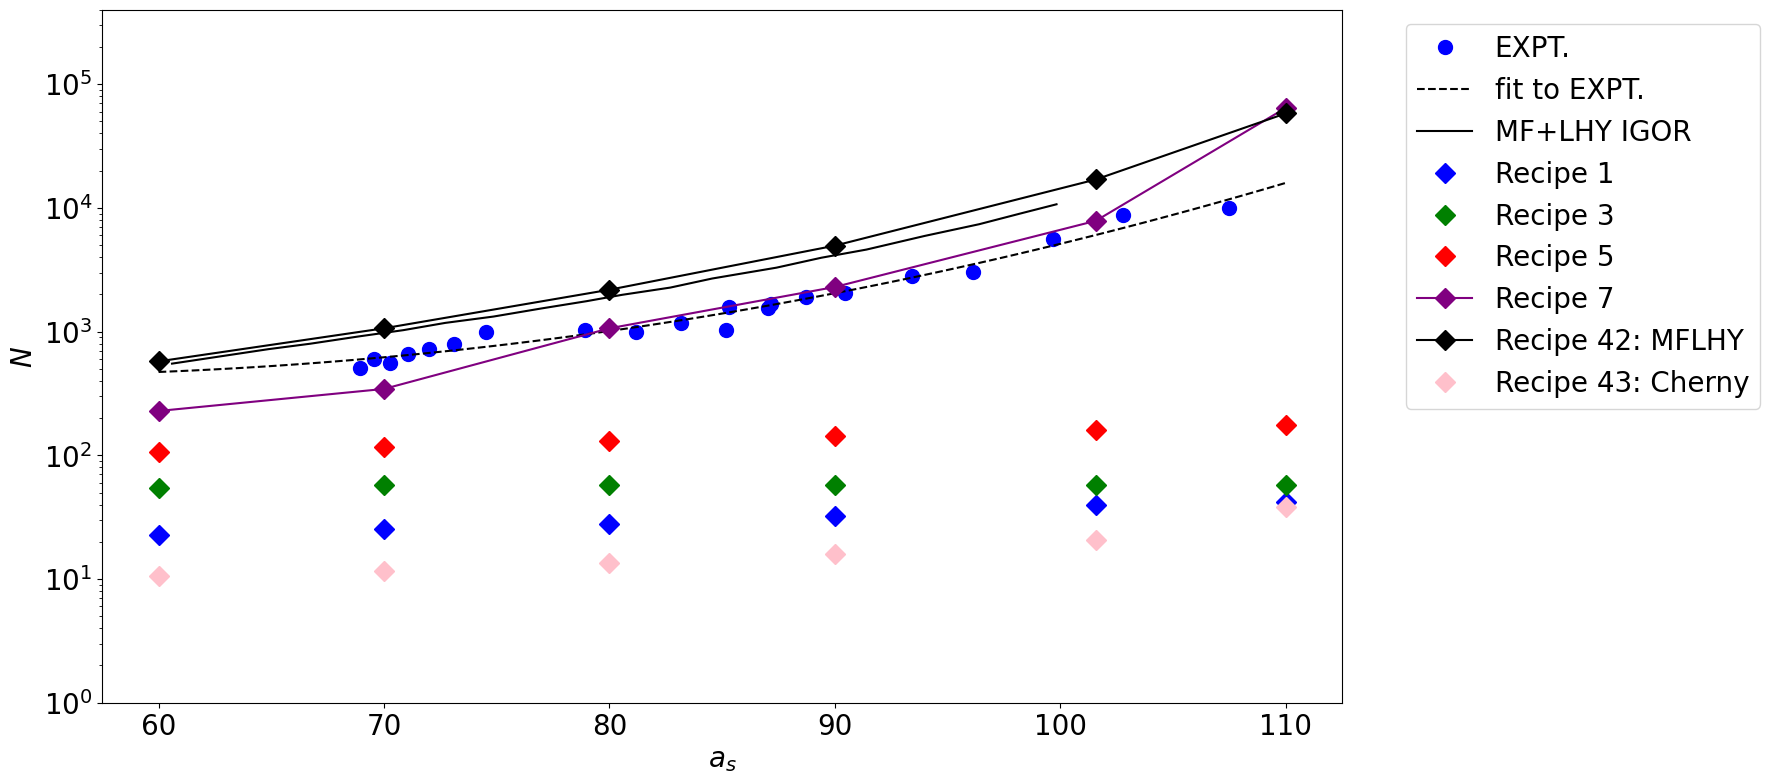

In [34]:

plt.figure(figsize=(16, 9))

def log_func_fit(x, a, b, c):
    return a*x**2 + b*x + c
def func_fit(x, a, b, c):
    return np.exp(log_func_fit(x, a, b, c))
data = np.loadtxt("./experimental-data/combined-critical-atom-number.dat")
sclen_expt = data[:,0]
nc_expt = data[:,1]
popt, pcov = curve_fit(f=log_func_fit, xdata=sclen_expt, ydata=np.log(nc_expt))

plt.plot(sclen_expt, nc_expt, label="EXPT.", ls='', marker='o', color='blue', markersize=10)
x = np.linspace(60, 110, num = 100)
plt.plot(x, func_fit(x, popt[0], popt[1], popt[2]), label="fit to EXPT.", color='black', ls = '--', markersize=10)


mf_data = np.loadtxt("./experimental-data/mean_field_IGOR.dat")
sclen_mf = mf_data[:,0]
nc_mf = mf_data[:,1]
plt.plot(sclen_mf, nc_mf, label="MF+LHY IGOR", color='black', markersize=10)

data = np.loadtxt("./results/critical-atom-numbers/recipe-1-nc/functionals_E_N.dat")
sclen = data[:,0]
nc = data[:,1]
plt.plot(sclen, nc, label="Recipe 1", color='blue', marker='D', ls='', markersize=10)

data = np.loadtxt("./results/critical-atom-numbers/recipe-3-nc/functionals_E_N.dat")
sclen = data[:,0]
nc = data[:,1]
plt.plot(sclen, nc, label="Recipe 3", color='green', marker='D', ls='', markersize=10)

data = np.loadtxt("./results/critical-atom-numbers/recipe-5-nc/functionals_E_N.dat")
sclen = data[:,0]
nc = data[:,1]
plt.plot(sclen, nc, label="Recipe 5", color='red', marker='D', ls='', markersize=10)

# data = np.loadtxt("./results/critical-atom-numbers/recipe-6-nc/functionals_E_N.dat")
# sclen = data[:,0]
# nc = data[:,1]
# plt.plot(sclen, nc, label="Recipe 6", color='orange', marker='D', ls='', markersize=10)

data = np.loadtxt("./results/critical-atom-numbers/recipe-7-nc/functionals_E_N.dat")
sclen = data[:,0]
nc = data[:,1]
# sort data by sclen
sclen, nc = (list(t) for t in zip(*sorted(zip(sclen, nc))))
plt.plot(sclen, nc, label="Recipe 7", color='purple', marker='D', ls='-', markersize=10)



data = np.loadtxt("./results/critical-atom-numbers/recipe-42-nc/functionals_E_N.dat")
sclen = data[:,0]
nc = data[:,1]
plt.plot(sclen, nc, label="Recipe 42: MFLHY", color='black', marker='D', ls='-', markersize=10)


data = np.loadtxt("./results/critical-atom-numbers/recipe-43-nc/functionals_E_N.dat")
sclen = data[:,0]
nc = data[:,1]
plt.plot(sclen, nc, label="Recipe 43: Cherny", color='pink', marker='D', ls='', markersize=10)


plt.xlabel(r'$a_s$', fontsize=20)
plt.ylabel(r'$N$', fontsize=20)
plt.legend(loc = "best", bbox_to_anchor=(1.04, 1), fontsize=20)

plt.ylim(4E+01, 2e4)

plt.yscale('log')
plt.ylim(1, 400000)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Save the figure into plots folder
plt.savefig(f"plots/critical-atom-number.pdf", bbox_inches='tight', dpi=300)
plt.savefig(f"plots/critical-atom-number.png", bbox_inches='tight', dpi=300)
